In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab_DL_ex1')

In [ ]:
import sys
!{sys.executable} -m pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1

In [ ]:
!{sys.executable} -m pip install matplotlip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from wideresnet import WideResNet
import logging
import shutil
import os
import matplotlib.pyplot as plt



torch.manual_seed(0)
np.random.seed(0)

In [ ]:
data_dir = "/content/drive/My Drive/Lab_DL_ex1/data"

In [ ]:
exp_name = "/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log"


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w')

In [ ]:
def construct_datasets(data_dir, batch_size):
    def data2loader_train(tr_data):
        train_loader = torch.utils.data.DataLoader(
            tr_data,
            batch_size=batch_size,
            shuffle=True)
        return train_loader

    def data2loader_test(te_data):
        test_loader = torch.utils.data.DataLoader(
            te_data,
            batch_size=batch_size,
            shuffle=False)

        return test_loader

    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize])

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)
    print("Train set number of items ", len(train_data))
    print("Val set number of items ", len(test_data))

    return data2loader_train(train_data), data2loader_test(test_data)

In [ ]:
batch_size = 128
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Train set number of items  50000
Val set number of items  10000


In [ ]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))



In [ ]:

def train_model(num_iters, train_loader, model):

  # Train loop

  for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)
    #ce_loss = criterion(output, target)


    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


      # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

    print_freq = 391

    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        #print("Epoch ", epoch)
        print("Validation set acc", prec1)
        logfile.write('validation set acc: ' + str(prec1) + '\n')




  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  logfile.close()





Ζητούμενο 1 και 2.

Στο παρακάτω κελί φαίνεται ένα παράδειγμα ενός wide residual network.
Διαβάζοντας το paper θα πρέπει να βρείτε τις παραμέτρους για τα 3 καλύτερα μοντέλα που προτείνονται στο paper.

Χρησιμοποιείστε το παρακάτω κελί ως template και σχολιάστε τις επιλογές σας σε markdown κελί κάνοντας αναφορά στο paper.



In [ ]:
# Model Parameters cell template

num_epochs = 20

num_iters = 391 * num_epochs  

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers = 40  
num_classes = 10  
widen_factor = 2
droprate =  0.0
lr = 0.1  
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model)

In [ ]:
# Model Parameters cell 1 with dropout

layers = 28 # total number of layers of wrn (wide residual network)
num_classes = 10   
widen_factor = 10
droprate = 0.3  
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()



criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)



state = {
    'epoch': 1 + 1,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler' : scheduler.state_dict()

}

torch.save(state, "/content/drive/My Drive/Lab_DL_ex1/best_model.tar/")

Validation set acc 0.4688
Validation set acc 0.6876
Validation set acc 0.6854
Validation set acc 0.7143
Validation set acc 0.7999
Validation set acc 0.8307
Validation set acc 0.7923
Validation set acc 0.8113
Validation set acc 0.8486
Validation set acc 0.8538
Validation set acc 0.8564
Validation set acc 0.8884
Validation set acc 0.8941
Validation set acc 0.9007
Validation set acc 0.9148
Validation set acc 0.9233
Validation set acc 0.9261
Validation set acc 0.9323
Validation set acc 0.9342
Cifar accuracy (0.001687717629224062, 0.9341)


In [ ]:
# Model Parameters cell 1 without dropout

layers = 28
num_classes = 10   
widen_factor = 10
droprate = 0  
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()



criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

state = {
    'epoch': 21,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler' : scheduler.state_dict()

}

torch.save(state, "/content/drive/My Drive/Lab_DL_ex1/best_model_28.tar/")

Validation set acc 0.533
Validation set acc 0.6435
Validation set acc 0.7784
Validation set acc 0.8007
Validation set acc 0.811
Validation set acc 0.8209
Validation set acc 0.8487
Validation set acc 0.8335
Validation set acc 0.8338
Validation set acc 0.8678
Validation set acc 0.8698
Validation set acc 0.8901
Validation set acc 0.8923
Validation set acc 0.8983
Validation set acc 0.9242
Validation set acc 0.9253
Validation set acc 0.9361
Validation set acc 0.9378
Validation set acc 0.9405
Cifar accuracy (0.001655852633435279, 0.9397)


In [ ]:

# Model Parameters cell 2 with dropout

layers = 16 
num_classes = 10   
widen_factor = 8
droprate = 0.3  
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.5366
Validation set acc 0.6021
Validation set acc 0.7474
Validation set acc 0.7794
Validation set acc 0.7491
Validation set acc 0.8303
Validation set acc 0.8087
Validation set acc 0.8239
Validation set acc 0.8423
Validation set acc 0.8362
Validation set acc 0.8749
Validation set acc 0.8844
Validation set acc 0.8948
Validation set acc 0.9044
Validation set acc 0.9098
Validation set acc 0.9194
Validation set acc 0.9257
Validation set acc 0.9289
Validation set acc 0.933
Cifar accuracy (0.0016945651188492775, 0.9312)


In [ ]:
# Model Parameters cell 2 without dropout

layers = 16 
num_classes = 10   
widen_factor = 8
droprate = 0  
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.5726
Validation set acc 0.6225
Validation set acc 0.7422
Validation set acc 0.7729
Validation set acc 0.749
Validation set acc 0.8034
Validation set acc 0.8517
Validation set acc 0.8383
Validation set acc 0.8582
Validation set acc 0.8447
Validation set acc 0.8647
Validation set acc 0.8835
Validation set acc 0.8891
Validation set acc 0.9062
Validation set acc 0.9157
Validation set acc 0.9249
Validation set acc 0.9321
Validation set acc 0.9339
Validation set acc 0.9364
Cifar accuracy (0.0016516339205205441, 0.9354)


In [ ]:
# Model Parameters cell 3 with dropout

layers = 40 
num_classes = 10  
widen_factor = 4
droprate = 0.3  
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  # number of total epochs to run

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.5247
Validation set acc 0.6666
Validation set acc 0.7251
Validation set acc 0.7552
Validation set acc 0.7681
Validation set acc 0.7648
Validation set acc 0.8033
Validation set acc 0.8331
Validation set acc 0.8038
Validation set acc 0.8408
Validation set acc 0.849
Validation set acc 0.8679
Validation set acc 0.8873
Validation set acc 0.8926
Validation set acc 0.8889
Validation set acc 0.907
Validation set acc 0.9148
Validation set acc 0.9197
Validation set acc 0.923
Cifar accuracy (0.0018352833267301322, 0.9232)


In [ ]:
# Model Parameters cell 3 without dropout

layers = 40
num_classes = 10   
widen_factor = 4
droprate = 0 
lr = 0.1  
weight_decay = 0.0005

num_epochs = 20

num_iters = 391 * num_epochs  
model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.5842
Validation set acc 0.6499
Validation set acc 0.7079
Validation set acc 0.7748
Validation set acc 0.7819
Validation set acc 0.7589
Validation set acc 0.7498
Validation set acc 0.8468
Validation set acc 0.8525
Validation set acc 0.8527
Validation set acc 0.8642
Validation set acc 0.8776
Validation set acc 0.8787
Validation set acc 0.9054
Validation set acc 0.914
Validation set acc 0.9078
Validation set acc 0.9271
Validation set acc 0.9313
Validation set acc 0.9333
Cifar accuracy (0.0018065235257148742, 0.9338)


In [ ]:

class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

      
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format 
        
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and self.mixup and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            mixup_label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            lam = np.random.beta(1,1)

            image = lam*image + (1-lam)*mixup_image
            label = lam*label + (1-lam)*mixup_label

        return image, label

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [ ]:
# Evaluation scripts


def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            #targets = targets.cuda(non_blocking=True).long()
            #images = images.cuda(non_blocking=True).float()
            logits = net(images)
            pred = logits.data.max(1)[1]
            #total_correct += pred.eq(targets.data).sum().item()
            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)


def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    softmpreds = []####
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]

            softscores = nn.Softmax(dim=1)(logits)####
            softscores = softscores.data.max(1)[0]####

            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()

            softmpreds = softmpreds+softscores.tolist()####
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset),softmpreds


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    softmpreds = []####

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc,softmpredsbatch = test_cifar(test_loader, net) ####
        softmpreds=softmpreds+softmpredsbatch.copy()####
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs)),softmpreds





In [ ]:
# Utils scripts

def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


Ζητούμενο 3: βήμα 1

Κάντε train το καλύτερο μοντέλο που βρήκατε (και αποθηκεύσατε) στα βήματα 1 και 2 χωρίς το mixup

In [ ]:


# train best models from 1 and 2 without mixup

num_epochs = 20

num_iters = 391 * num_epochs  

batch_size = 128

print_freq = 391 

layers = 28  
num_classes = 10  
widen_factor = 10
droprate = 0.3 
lr = 0.1  
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',', 0, transform, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

checkpoint = torch.load("/content/drive/My Drive/Lab_DL_ex1/best_model_28.tar")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']


# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = bceloss(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        tress,softpreds_withoutmixup = test_c_cifar(model)
        print('Average Cifar-C accuracy {}'.format(tress))
        epoch += 1

t =  391
Epoch  0
Validation set acc 0.9277
Weather
	 Test Acc 0.708
Blur
	 Test Acc 0.531
Noise
	 Test Acc 0.275
Digital
	 Test Acc 0.655
Average Cifar-C accuracy 0.5425362499999999
t =  782
Epoch  1
Validation set acc 0.9279
Weather
	 Test Acc 0.708
Blur
	 Test Acc 0.517
Noise
	 Test Acc 0.274
Digital
	 Test Acc 0.654
Average Cifar-C accuracy 0.5379875
t =  1173
Epoch  2
Validation set acc 0.9274
Weather
	 Test Acc 0.703
Blur
	 Test Acc 0.526
Noise
	 Test Acc 0.267
Digital
	 Test Acc 0.657
Average Cifar-C accuracy 0.5383345833333333
t =  1564
Epoch  3
Validation set acc 0.928
Weather
	 Test Acc 0.710
Blur
	 Test Acc 0.527
Noise
	 Test Acc 0.277
Digital
	 Test Acc 0.654
Average Cifar-C accuracy 0.5419270833333333
t =  1955
Epoch  4
Validation set acc 0.9274
Weather
	 Test Acc 0.710
Blur
	 Test Acc 0.527
Noise
	 Test Acc 0.280
Digital
	 Test Acc 0.652
Average Cifar-C accuracy 0.54199375
t =  2346
Epoch  5
Validation set acc 0.9282
Weather
	 Test Acc 0.705
Blur
	 Test Acc 0.518
Noise
	 

In [ ]:
# Model parameters


num_epochs = 20

num_iters = 391 * num_epochs  

batch_size = 128

print_freq = 391 

layers = 28 
num_classes = 10   
widen_factor = 10
droprate = 0.3  
lr = 0.1  
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0


checkpoint = torch.load("/content/drive/My Drive/Lab_DL_ex1/best_model_28.tar")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']


epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = bceloss(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        tress_mixup,softpreds_withmixup = test_c_cifar(model)
        print('Average Cifar-C accuracy {}'.format(tress_mixup))
        epoch += 1

t =  391
Epoch  0
Validation set acc 0.9265
Weather
	 Test Acc 0.712
Blur
	 Test Acc 0.525
Noise
	 Test Acc 0.265
Digital
	 Test Acc 0.655
Average Cifar-C accuracy 0.5391845833333333
t =  782
Epoch  1
Validation set acc 0.9256
Weather
	 Test Acc 0.706
Blur
	 Test Acc 0.517
Noise
	 Test Acc 0.260
Digital
	 Test Acc 0.656
Average Cifar-C accuracy 0.5348145833333333
t =  1173
Epoch  2
Validation set acc 0.9228
Weather
	 Test Acc 0.712
Blur
	 Test Acc 0.517
Noise
	 Test Acc 0.267
Digital
	 Test Acc 0.651
Average Cifar-C accuracy 0.5367283333333334
t =  1564
Epoch  3
Validation set acc 0.9256
Weather
	 Test Acc 0.711
Blur
	 Test Acc 0.522
Noise
	 Test Acc 0.265
Digital
	 Test Acc 0.655
Average Cifar-C accuracy 0.5382829166666666
t =  1955
Epoch  4
Validation set acc 0.9246
Weather
	 Test Acc 0.709
Blur
	 Test Acc 0.517
Noise
	 Test Acc 0.262
Digital
	 Test Acc 0.655
Average Cifar-C accuracy 0.5356204166666667
t =  2346
Epoch  5
Validation set acc 0.924
Weather
	 Test Acc 0.711
Blur
	 Test A

# Παρατηρήσεις

### Αποτελέσματα

|                     | Without Mixup | With Mixup   |
|---------------------|---------------|--------------|
| Validation set acc   | 0.9299        | 0.9264       |
| Weather Test Acc     | 0.710         | 0.713        |
| Blur Test Acc        | 0.523         | 0.528        |
| Noise Test Acc       | 0.275         | 0.270        |
| Digital Test Acc     | 0.654         | 0.655        |
| Average Cifar-C Acc  | 0.540375833   | 0.541297083  |


Η χρήση mixup βοηθά στο generalization του μοντέλου, αποφεύγοντας, έτσι, το overfitting. Όπως φαίνεται και από τον παραπάνω πίνακα, τα καλύτερα αποτελέσματα για το Cifar-C set προκύπτουν με mixup, ενώ για το CIFAR-10 set χωρίς mixup. Λόγω της μεγαλύτερης γενίκευσης που επιτυγχάνει το μοντέλο με mixup, είναι πιο εύκολη η αναγνώριση αντικειμένου τροποποιημένης εικόνας (εικόνας με θόρυβο), καθώς δεν επικεντρώνεται στις λεπτομέρειες και προσπαθεί να εντοπίσει πιο "αντικειμενικά" κριτήρια - χαρακτηριστικά. Αντίθετα, χωρίς τη χρήση mixup το μοντέλο "μαθαίνει" καλύτερα το συγκεκριμένο training set (CIFAR-10), με αποτέλεσμα να έχει μεγαλύτερη ακρίβεια όταν ελέγχεται σε αρκετά παρόμοιες με αυτό εικόνες (εικόνες χωρίς θόρυβο).


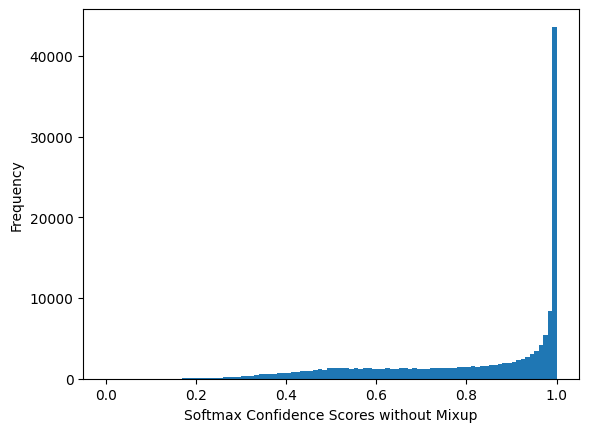

In [ ]:
# Plot the confidence scores for CIFAR-C with WRN model
# trained with and without mixup and comment
plt.hist(softpreds_withoutmixup,bins=100,range=[0,1])
plt.xlabel('Softmax Confidence Scores without Mixup')
plt.ylabel('Frequency')
plt.show()

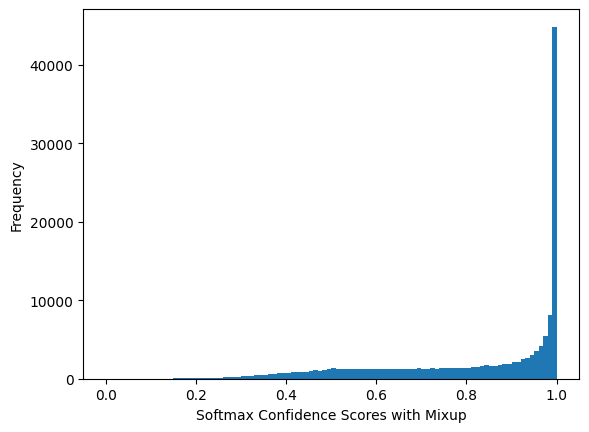

In [ ]:
plt.hist(softpreds_withmixup,bins=100,range=[0,1])
plt.xlabel('Softmax Confidence Scores with Mixup')
plt.ylabel('Frequency')
plt.show()

## Παρατηρήσεις

Και τα δύο μοντέλα εμφανίζουν αρκετά παρόμοια confidence scores αναγνώρισης αντικειμένων, τα οποία συνήθως έχουν μεγάλες τιμές (>98%). Φαίνεται, λοιπόν, ότι το mixup δεν έχει ιδιαίτερη επιρροή στη βεβαιότητα του μοντέλου, γεγονός για το οποίο πιθανόν ευθύνεται το ίδιο το dataset (πχ. είναι biased, είναι εύκολο στην ταξινόμηση - οι κλάσεις που περιλαμβάνει είναι well separated).

Σημείωση: Για την εξαγωγή των παραπάνω γραφικών παραστάσεων, τροποποιήσαμε κατάλληλα τις συναρτήσεις test_cifar και test_c_cifar έτσι ώστε να παράγουμε και να αποθηκεύουμε τα softmax predictions κατά τη διαδικασία του testing σε μία λίστα η οποία χρησιμοποιείται μετά για τη σχεδίαση των εν λόγω γραφικών.